In [1]:
import numpy as np
from TEMPO import TEMPO
from iTEBD_TEMPO import iTEBD_TEMPO
import matplotlib.pyplot as plt
from scipy.special import gamma
import qutip as qt

# Bath and System Paramters

The bath is a single exponential. This corresponds to the response of a single damped cavity mode.

In [2]:
G = 1
W = 1 + 1j * 1
BCF = lambda t: G * np.exp(-1j * t * W.imag - np.abs(t) * W.real)

For the system we choose a spin-$j$. The coupling operator is $J_z$. The initial state is a random coherent state.

In [3]:
Delta = .05
N_c = 200
j = 1
L = qt.operators.jmat(j, 'z').full() / j
H = qt.operators.jmat(j, 'x').full() + .2 * qt.operators.jmat(j, 'y').full()
Rho_0 = qt.ket2dm(qt.spin_coherent(j, np.pi / 2 * np.random.rand(), np.pi / 2 * np.random.rand())).full()

These are the parameters for the time evolution

In [4]:
Delta = 0.1
T_max = 20
N = int(T_max / Delta)
T_eval = np.linspace(0, N * Delta, N + 1)

# Exact solution via Qutip 

We can get the exact dynamics from qutip by simulating the Markovian dynamics of the system and cavity mode.

In [5]:
NC = 20 # maximum dimension of pseudomode
NS = int(2 * j + 1)
a = qt.destroy(NC)
S1 = qt.qeye(NS)
C1 = qt.qeye(NC)
Htot = qt.tensor(qt.Qobj(H), C1) + np.sqrt(G) * (qt.tensor(qt.Qobj(L), a.dag()) + qt.tensor(qt.Qobj(L).dag(), a)) + W.imag * qt.tensor(S1, a.dag() * a)
sol_qt = qt.mesolve(Htot, qt.tensor(qt.Qobj(Rho_0), qt.ket2dm(qt.basis(NC, 0))), T_eval, [np.sqrt(W.real * 2) * qt.tensor(S1, a)], [])

# TEMPO

This is a finite-size PT-TEMPO computation https://doi.org/10.1103/PhysRevLett.123.240602. One can also set a memory cutoff $N_c<N$ if applicable. Note that this code is not optimal and not recommended for serious computations. Instead, use the sophisticated implementation from OQuPy https://oqupy.readthedocs.io/en/latest/. 

In [6]:
MyTEMPO = TEMPO(np.diagonal(L), Delta, BCF, N)

This computes the influence functional. rtol determines the accuracy.

In [7]:
MyTEMPO.compute_f(rtol=1e-6, contraction='Jorgensen')

building influence functional: 100%|███████████████| 199/199 [01:47<00:00,  1.84it/s]

ranks:  (10, 7, 9, 10, 12, 13, 14, 14, 16, 17, 19, 20, 21, 22, 22, 22, 24, 25, 25, 24, 24, 24, 24, 23, 24, 26, 27, 28, 29, 30, 30, 30, 31, 30, 30, 31, 32, 33, 32, 34, 32, 32, 33, 35, 35, 34, 34, 34, 35, 34, 35, 35, 35, 33, 33, 33, 33, 34, 34, 35, 34, 34, 34, 34, 35, 35, 35, 34, 35, 33, 34, 35, 33, 32, 32, 29, 30, 32, 31, 30, 29, 31, 29, 29, 29, 29, 28, 28, 29, 30, 30, 30, 29, 28, 29, 29, 28, 28, 28, 29, 29, 27, 28, 28, 29, 28, 26, 25, 27, 27, 28, 28, 28, 29, 30, 31, 32, 33, 31, 30, 30, 31, 32, 30, 30, 31, 32, 31, 33, 31, 31, 32, 31, 32, 33, 33, 31, 34, 33, 33, 33, 33, 33, 31, 34, 33, 34, 32, 33, 32, 32, 31, 32, 31, 29, 29, 28, 30, 30, 28, 28, 27, 28, 28, 29, 29, 28, 29, 29, 29, 29, 29, 29, 27, 27, 26, 26, 24, 25, 24, 24, 25, 25, 25, 24, 22, 23, 21, 22, 21, 20, 18, 18, 17, 16, 15, 13, 10, 7)


Then one can perform time evolution for any hamiltonian and initial state.

In [8]:
Rho_t_tempo = MyTEMPO.evolve(H, Rho_0)

time evolution running: 100%|█████████████████████| 200/200 [00:00<00:00, 958.80it/s]


We obtain the exact dynamics.

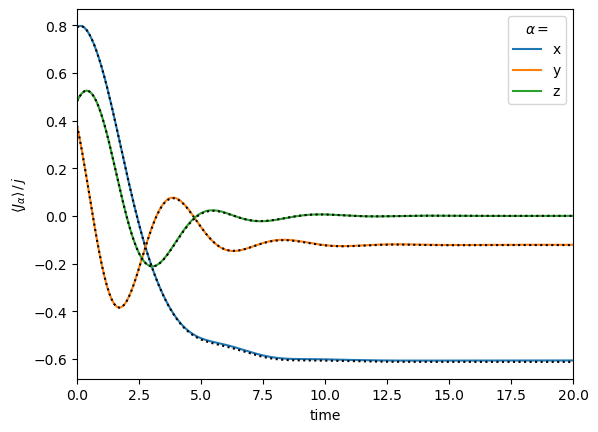

In [9]:
def expect(x,o):
    return np.einsum('ij,tji->t',o,x)

for i in ['x','y','z']:
    plt.plot(T_eval,expect(Rho_t_tempo, qt.operators.jmat(j,i)).real / j, label=i)
    plt.plot(T_eval,qt.expect(sol_qt.states, qt.tensor(qt.operators.jmat(j, i), C1)).real / j, c='k', ls='dotted')

plt.xlim(T_eval.min(), T_eval.max())
plt.xlabel('time')
plt.ylabel(r'$\langle J_\alpha \rangle\, /\, j$')
plt.legend(title=r'$\alpha=$')

# iTEBD-TEMPO

The same calculation using iTEBD-TEMPO. This has a much better scaling.

In [10]:
MyiTEBD_TEMPO = iTEBD_TEMPO(np.diagonal(L), Delta, BCF, 1000)

In [11]:
MyiTEBD_TEMPO.compute_f(rank=100, rtol=1e-6)

building influence functional: 100%|███████████| 1000/1000 [00:00<00:00, 2061.90it/s]

rank  14


For iTEBD-TEMPO one has to pass the number of time steps $N$ to the evolve function. $N$ can be arbitrary here.

In [12]:
Rho_t = MyiTEBD_TEMPO.evolve(H, Rho_0, N)

time evolution running: 100%|████████████████████| 200/200 [00:00<00:00, 3927.82it/s]


We can also compute the steady state directly.

In [13]:
Rho_ss = MyiTEBD_TEMPO.steadystate(H)

Again we obtain the exact dynamics.

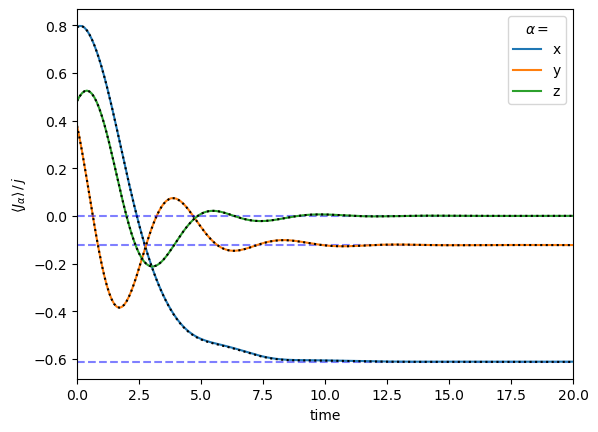

In [14]:
def expect(x, o):
    return np.einsum('ij,tji->t', o, x)

for i in ['x','y','z']:
    plt.plot(T_eval,0*T_eval+np.trace(Rho_ss @ qt.operators.jmat(j,i).full()).real / j, c='b',ls='--', alpha=.5)
    plt.plot(T_eval,expect(Rho_t, qt.operators.jmat(j,i)).real / j, label=i)
    plt.plot(T_eval,qt.expect(sol_qt.states, qt.tensor(qt.operators.jmat(j, i), C1)).real / j, c='k', ls='dotted')

plt.xlim(T_eval.min(), T_eval.max())
plt.xlabel('time')
plt.ylabel(r'$\langle J_\alpha \rangle\, /\, j$')
plt.legend(title=r'$\alpha=$')